In [ ]:
# For data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# For deep learning
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
# loading the data
df = pd.read_csv("/content/data2.csv")
df.head()

,pixel_0000,pixel_0001,pixel_0002,pixel_0003,pixel_0004,pixel_0005,pixel_0006,pixel_0007,pixel_0008,pixel_0009,...,pixel_1015,pixel_1016,pixel_1017,pixel_1018,pixel_1019,pixel_1020,pixel_1021,pixel_1022,pixel_1023,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

x_train, x_test = train_df.drop('character', axis=1), test_df.drop('character', axis=1)
y_train, y_test = train_df['character'], test_df['character']

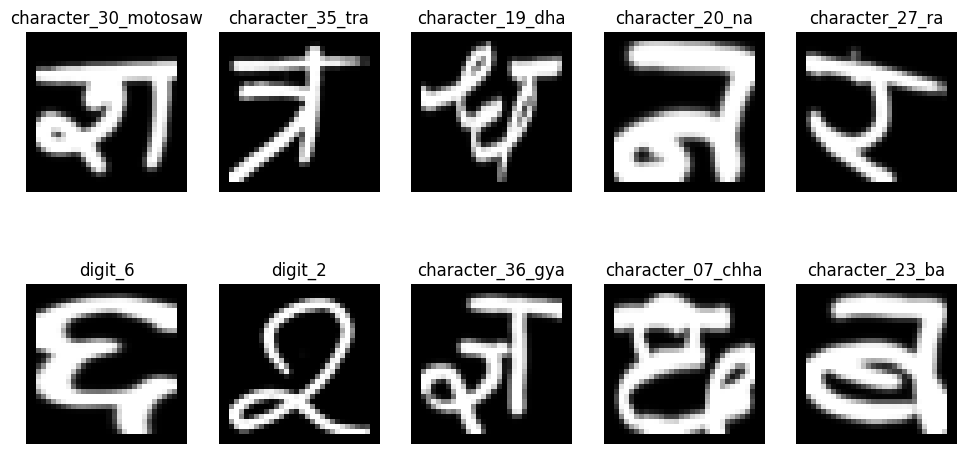

In [ ]:
# Plotting some training images along with their labels
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12,6))
idxs = y_train.index

for row in ax:
    for col in row:
        idx = random.choice(idxs)
        col.axis('off')
        col.set_title(y_train[idx])
        col.imshow(x_train[idx], cmap=plt.get_cmap('gray'))

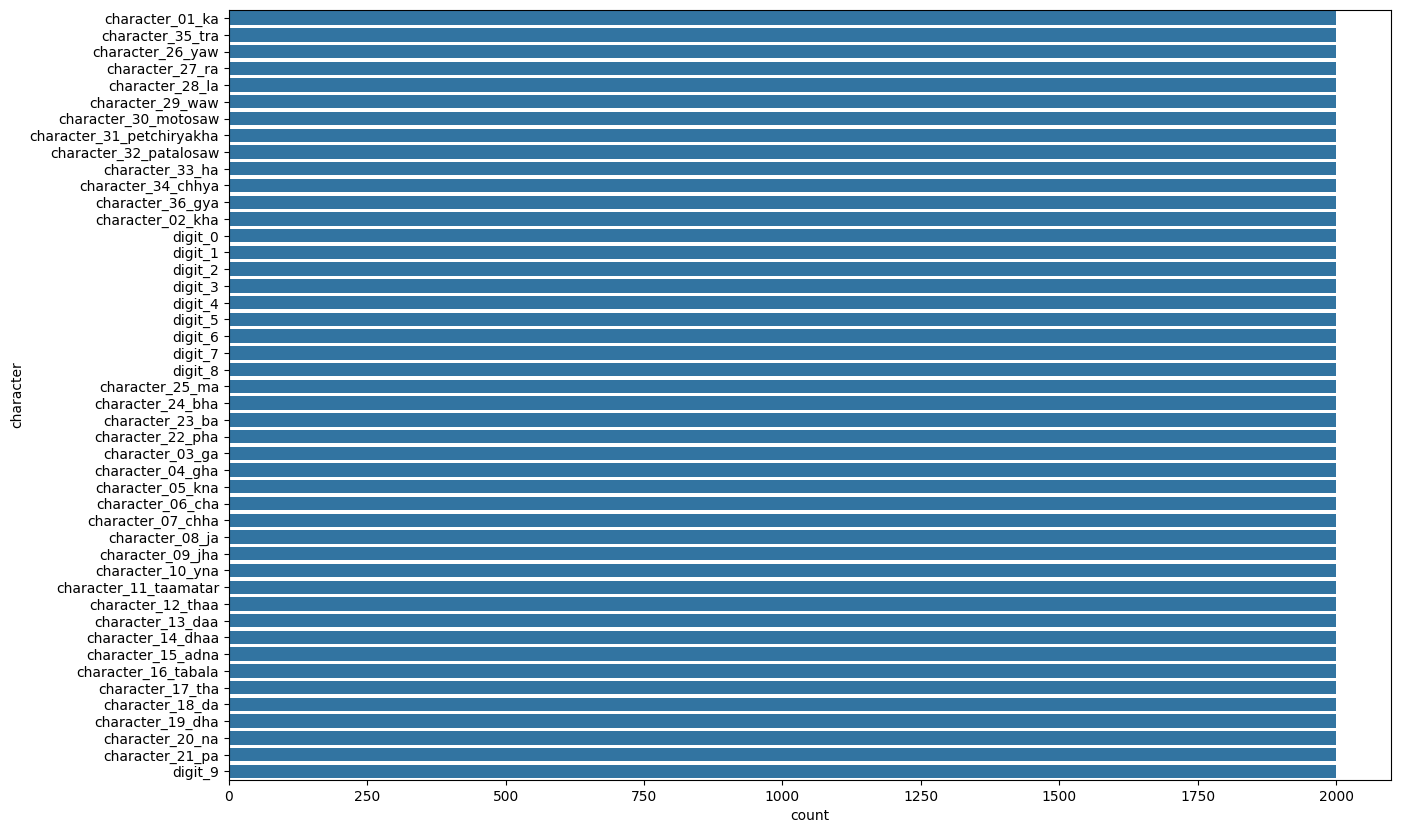

In [ ]:
# Plotting distribution of output classes
data = df.character.value_counts()
plt.figure(figsize=(15, 10))
sns.barplot(y = data.index, x = data, orient='h')
plt.show()

In [ ]:
all_chars = df['character'].unique()

print(f'All characters: {all_chars}')
print(f"Number of characters: {len(all_chars)}")

All characters: ['character_01_ka' 'character_02_kha' 'character_03_ga' 'character_04_gha'
 'character_05_kna' 'character_06_cha' 'character_07_chha'
 'character_08_ja' 'character_09_jha' 'character_10_yna'
 'character_11_taamatar' 'character_12_thaa' 'character_13_daa'
 'character_14_dhaa' 'character_15_adna' 'character_16_tabala'
 'character_17_tha' 'character_18_da' 'character_19_dha' 'character_20_na'
 'character_21_pa' 'character_22_pha' 'character_23_ba' 'character_24_bha'
 'character_25_ma' 'character_26_yaw' 'character_27_ra' 'character_28_la'
 'character_29_waw' 'character_30_motosaw' 'character_31_petchiryakha'
 'character_32_patalosaw' 'character_33_ha' 'character_34_chhya'
 'character_35_tra' 'character_36_gya' 'digit_0' 'digit_1' 'digit_2'
 'digit_3' 'digit_4' 'digit_5' 'digit_6' 'digit_7' 'digit_8' 'digit_9']
Number of characters: 46


In [ ]:
# Converting data frame to image arrays
x_train, x_test = x_train.values.reshape(x_train.values.shape[0], 32, 32), x_test.values.reshape(x_test.values.shape[0], 32, 32)

print(f'Shape of Training Image array: {x_train.shape}')
print(f'Shape of Testing Image array: {x_test.shape}')

Shape of Training Image array: (73600, 32, 32)
Shape of Testing Image array: (18400, 32, 32)


In [ ]:
# Label encoding the output classes
labelencoder = LabelEncoder()

Y_train = labelencoder.fit_transform(y_train)
X_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

Y_test = labelencoder.fit_transform(y_test)
X_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [ ]:
# Detect hardware
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError: # If TPU not found
    tpu = None

In [ ]:
# Select appropriate distribution strategy
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
else:
    strategy = tf.distribute.get_strategy() # Default strategy that works on CPU and single GPU
    print('Running on CPU instead')

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on CPU instead
Number of accelerators:  1


In [ ]:
with strategy.scope():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(46))

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    # Display the architecture
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [ ]:
if tpu:
    BATCH_SIZE = 400 * strategy.num_replicas_in_sync
else:
    BATCH_SIZE = 400

EPOCHS = 30
VALIDATION_SPLIT = 0.25

# Train the model
history = model.fit(X_train, Y_train, epochs=EPOCHS, validation_split=VALIDATION_SPLIT, batch_size=BATCH_SIZE)

# Save the model weights
model.save('./devnagari_model.h5', overwrite=True)

Epoch 1/30
138/138 [==============================] - 72s 523ms/step - loss: 0.1725 - accuracy: 0.9469 - val_loss: 0.2543 - val_accuracy: 0.9262
Epoch 2/30
138/138 [==============================] - 72s 525ms/step - loss: 0.1166 - accuracy: 0.9634 - val_loss: 0.1922 - val_accuracy: 0.9460
Epoch 3/30
138/138 [==============================] - 68s 490ms/step - loss: 0.0899 - accuracy: 0.9714 - val_loss: 0.1814 - val_accuracy: 0.9493
Epoch 4/30
138/138 [==============================] - 70s 503ms/step - loss: 0.0678 - accuracy: 0.9774 - val_loss: 0.1915 - val_accuracy: 0.9477
Epoch 5/30
138/138 [==============================] - 68s 492ms/step - loss: 0.0571 - accuracy: 0.9808 - val_loss: 0.1853 - val_accuracy: 0.9514
Epoch 6/30
138/138 [==============================] - 68s 494ms/step - loss: 0.0393 - accuracy: 0.9871 - val_loss: 0.1986 - val_accuracy: 0.9510
Epoch 7/30
138/138 [==============================] - 72s 522ms/step - loss: 0.0331 - accuracy: 0.9889 - val_loss: 0.1818 - val_ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


575/575 - 12s - loss: 0.1842 - accuracy: 0.9687 - 12s/epoch - 21ms/step


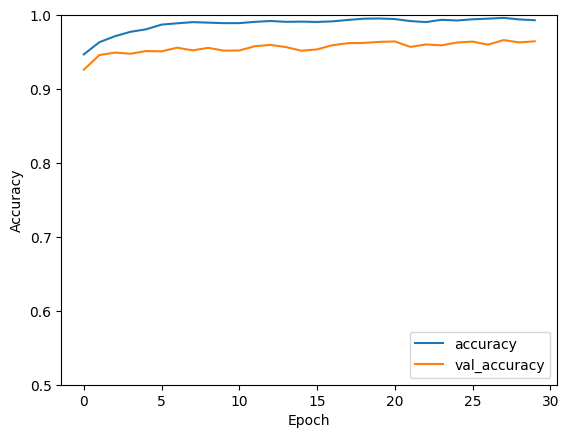

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# Show testing loss and accuracy
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)

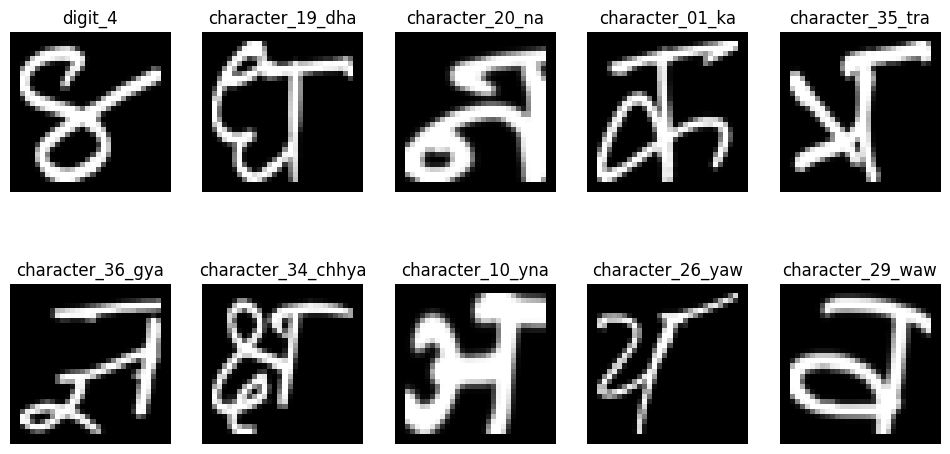

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12,6))
idxs = y_test.index

for row in ax:
    for col in row:
        idx = random.choice(idxs)
        x = X_test[idx].reshape(1, 32, 32, 1)
        logit_y = model(x)
        pred_y = labelencoder.inverse_transform(np.argmax(logit_y, axis=-1))
        col.axis('off')
        col.set_title(pred_y[0])
        col.imshow(x_test[idx], cmap=plt.get_cmap('gray'))